In [95]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os, sys
from sklearn.datasets import make_blobs, make_moons, make_circles, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from scipy.stats import mode
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

src=f"{os.getcwd()}/src"
if src not in sys.path:
    sys.path.append(src)
from SimpleClassifying import dibuja_frontera_2D
from SimpleClustering import plotPCA, plotClusters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# El Centroide más cercano

El modelo de centroides contraídos más cercanos (también conocido como PAM, por predictive analysis for microarrays o análisis predictivo para microarreglos) es un modelo de clasificación lineal que se adapta bien a problemas de alta dimensión. Para cada clase, el centroide de los datos se obtiene calculando el valor promedio de cada predictor (por clase) en el conjunto de entrenamiento. El centroide general se calcula utilizando los datos de todas las clases.


Si un predictor no contiene mucha información para una clase en particular, su centroide para esa clase probablemente esté cerca del centroide general. Consideremos los datos de tres clases mostrados del conjunto de datos es el famoso conjunto de iris ( recordemos que tiene cuatro mediciones de los sépalos y pétalos de iris para clasificar las flores en una de tres especies diferentes de iris: setosa, versicolor y virginica). En esta gráfica, los datos de las clases versicolor y virginica se superponen, pero están bien separados de los iris setosa. Los centroides  proyectados en dos dimensiones los podemos visualizar con  `plotPCA`.

In [33]:
bunch=load_iris()
data,target=bunch.get("data"),bunch.get("target")
data2d=PCA(n_components=2).fit_transform(data)

In [12]:
bunch.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [15]:
bunch.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [36]:
centroides={i:np.mean(data2d[target==i], axis=0) for i in set(target)}

In [37]:
centroides

{np.int64(0): array([-2.64241546,  0.19088505]),
 np.int64(1): array([ 0.53320657, -0.24554983]),
 np.int64(2): array([2.10920889, 0.05466479])}

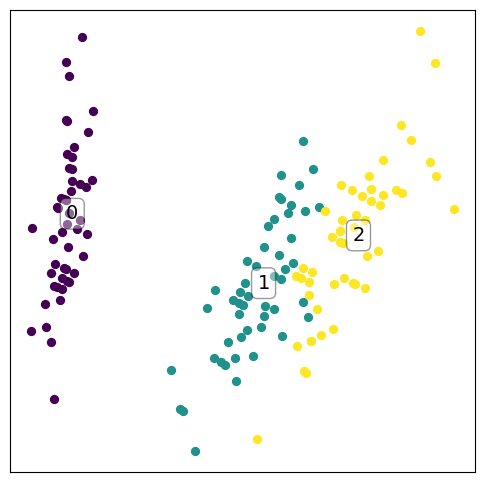

In [39]:
plotClusters(data2d[:,[0,1]],target, centroids=centroides)

Un enfoque para clasificar muestras desconocidas sería encontrar el centroide de clase más cercano en el espacio completo de dimensiones y elegir esa clase para la predicción (es decir, un modelo de “centroide más cercano”). Resulta que este enfoque daría lugar a fronteras de clase lineales.

In [73]:
## Vamos a implemetar la idea del nearest centroid
class NC:
    def fit(self,X, y):
        self.centroides={i:np.mean(X[y==i], axis=0) for i in set(y)}
        self.C=np.array([c for c  in self.centroides.values()])
    def predict(self, X):
        dist=pairwise_distances(X,self.C,metric=self.metric)
        return np.argsort(dist)[:,0]
    def __init__(self, metric='euclidean'):
        self.metric=metric

In [74]:
clf=NC()
clf.fit(data2d,target)
clf.C       

array([[-2.64241546,  0.19088505],
       [ 0.53320657, -0.24554983],
       [ 2.10920889,  0.05466479]])

In [75]:
clf.predict(data2d)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Prueba de Clasificación 

En este caso nos interesa clasificar muestras desconocidas, como para ellos solo contamos con `data` lo que haremos será dividir el conjunto en dos conjuntos:
1. un conjunto de entrenamiento que el algoritmo de aprendizaje utiliza para ajustar los parámetros. Para el caso de nearest centroid los parametros a ajustar son los centroides.
2. un conjunto de test para evaluar la capacidad de generalización del modelo

La función ``train_test_split`` del paquete ``model_selection`` hace justo esto por nosotros - la usaremos para generar una partición con un 70%//30% en entrenamiento y test, respectivamente.

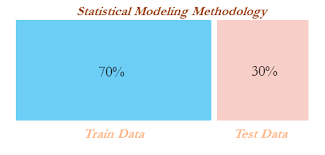

In [76]:
X_train, X_test, y_train, y_test = train_test_split(data2d, target,
                                                    test_size=0.30,
                                                    random_state=1,
                                                    stratify=target)

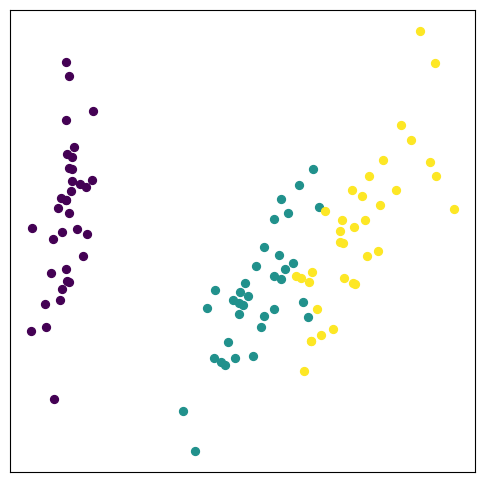

In [78]:
plotClusters(X_train,y_train)

In [84]:
clf=NC()
clf.fit(X_train,y_train)
clf.C  
yp=clf.predict(X_test)
sum(y_test==yp)/len(yp)

np.float64(0.8444444444444444)

(40000, 2) (200, 200)


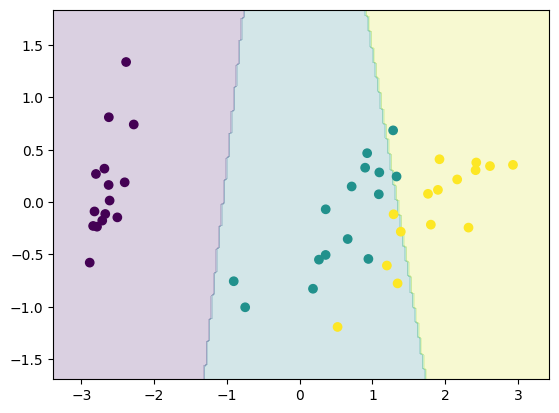

In [86]:
dibuja_frontera_2D(clf, X_test, y_test)

## Vecino más cercano (K Nearest Neighbors  KNN)


K-Nearest Neighbors (KNN) es un algoritmo supervisado de clasificación y regresión. Su principio básico es que, dado un objeto de clase desconocida, se determinan los $k$ objetos más cercanos en el  conjunto de entrenamiento y determinará su categoría en función de la clase mayoritaría de sus vecinos más cercanos, o bien como el promedio de salida de sus vecino más cercano  en el caso de la regresión.

### Pasos generales del KNN:

1. **Seleccionar el número de vecinos** \( k \) (es un hiper-parámetro).
2. **Calcular la distancia** entre $x_q$ y todos los puntos en el conjunto de datos de entrenamiento. La distancia euclidiana es una de las métricas más comunes y se calcula como:

$$d(x_q,x_i)=\sqrt{\Sigma_{j=1}^D (x_{q_j}-x_{i_j})^2}$$
   
   
   donde:
   - $x_q$ es el objeto de clase/salida desconicida.
   - $x_i$ es uno de los elmentos en el conjunto  entrenamiento $X$.
   - $n$ es el número de características o dimensiones.
   - $d$ La función de distancia


3. **Ordenar las distancias** y seleccionar los $k$ vecinos más cercanos.
4. **Clasificación**: En el caso de clasificación, se asigna  la categoría más frecuente entre sus $k$ vecinos.
   
   En términos de una función de predicción, esto se puede expresar como:

   
   $$ \hat{y} = \text{moda}(y_i), \quad \forall i \in N_k(x)$$
   donde $ N_k(x)$ representa el conjunto de los $k$ vecinos más cercanos, y $y_i$ es la clase del í-esimo vecino.

5. **Regresión**: En este caso, el valor a predecir será la media de los valores de los $k$ vecinos más cercanos:

  
   $$ \hat{y} = \frac{1}{k} \sum_{i \in N_k(x)} y_i$$

### Selección del valor de $k$:
- Si $k$ es pequeño, el modelo puede ser sensible al ruido y sobreajustarse (revisaremos este concepto en las siguientes seciones).
- Si $k$ es muy grande, el modelo puede perder la capacidad de capturar detalles locales y generar predicciones menos precisas.

Este algoritmo es sencillo pero puede ser computacionalmente costoso, ya que requiere calcular la distancia a todos los puntos del conjunto de entrenamiento para cada nuevo punto a clasificar o predecir.


### Parámetro $\epsilon$
Otra alternativa al parámetro  $k$  KNN, es  fijar  un radio $\epsilon$ para definir una "vecindad" alrededor del punto de interés. En este enfoque, en vez de seleccionar un número específico de vecinos más cercanos, se consideran todos los puntos que caen dentro del radio $\epsilon$ del punto de datos nuevo.

En este caso el conjunto $N_k$ se define como
   
   $$N_\epsilon(x) = \left\{ x_i \mid d(x_q, x_i) \leq \epsilon \right\}$$
  

#### Ventajas de usar $\epsilon$:

- **Flexibilidad**: No es necesario especificar un número exacto de vecinos, lo cual puede ser útil en áreas de baja densidad, ya que el número de vecinos cercanos puede variar.
- **Adaptabilidad**: En áreas donde los puntos de datos están más dispersos, $ \epsilon$ puede permitir una selección de vecinos más adaptada al espacio de características.

#### Consideraciones al usar $\epsilon$:

- Si $\epsilon$ es muy pequeño, es posible que no se encuentren suficientes vecinos para hacer una predicción confiable.
- Si $\epsilon$ es demasiado grande, se pueden incluir demasiados puntos lejanos, lo que reduce la precisión del modelo al incorporar puntos menos relevantes.


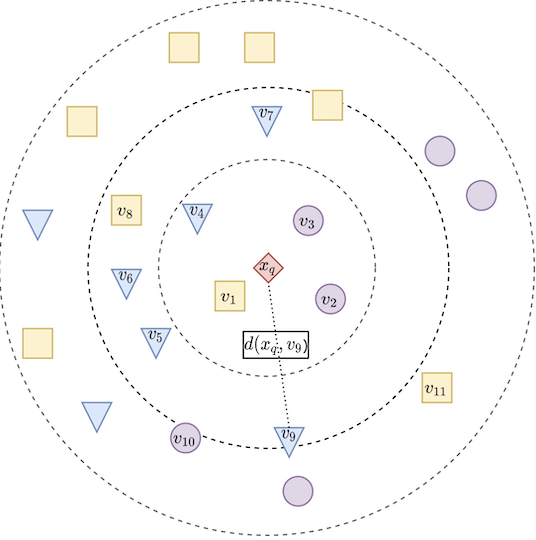

In [31]:
# Implementar KNN

In [63]:
np.argsort(pairwise_distances([[1,2],[2,1]],[[1,2],[2,1], [4,5], [3,6]]))


array([[0, 1, 2, 3],
       [1, 0, 2, 3]])

In [108]:
class KNN:
    def fit(self,X, y):
        self.data=X
        self.target=y
    def predict(self, X):
        dist=pairwise_distances(X, self.data,metric=self.metric)
        idx=np.argsort(dist)[:,:self.n_neighbors]
        yp,_=mode(self.target[idx],axis=1)
        return yp
    def __init__(self,n_neighbors=3, metric='euclidean'):
        self.metric=metric
        self.n_neighbors=n_neighbors

In [127]:
clfv=KNN(n_neighbors=11)

In [128]:
clfv.fit(X_train,y_train)

In [129]:
sum(clfv.predict(X_train)==y_train)/len(y_train)

np.float64(0.9428571428571428)

(40000, 2) (200, 200)


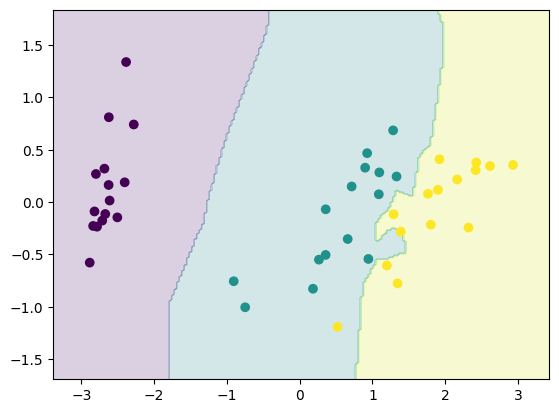

In [125]:
dibuja_frontera_2D(clfv,X_test, y_test)

In [99]:
moda

array([2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0,
       1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1, 1, 0,
       0])

In [134]:
Xc,yc=make_circles(noise=0.05)
Xl

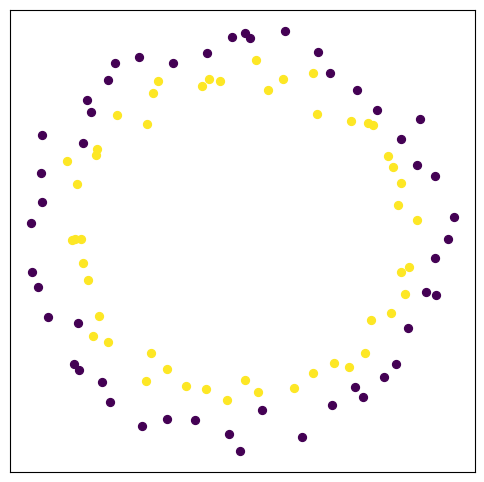

In [135]:
plotClusters(Xc,yc)